In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=6NPJ0MyU47P-XhP9asnamDwBaKPY-1PlSp_Iv6F_DLE&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWilW9NceWjGYR4B6USpZW9IkpkhE6AAZFKli-5BiuOBFCgLwKHS2gE

Successfully saved authorization token.


In [51]:
#@title def hist2otsu
###############################################################################
#####                           hist2otsu                                 #####
#####                        Evan Lahr, 2021                              #####
#####         Compute an Ostu threshold using only histogram data         #####
#####         Similar to MATLAB function 'otsuthresh' (link below)        #####
#####       https://www.mathworks.com/help/images/ref/otsuthresh.html     #####
#####                                                                     #####
#####   INPUT DATA must be a 2-column array of histogram information      #####
#####       COLUMN 1 must be the LOWER BIN EDGES of the histogram         #####
#####       COLUMN 2 must be the NORMALIZED COUNTS of the histogram       #####
##### OUTPUT is the otsu threshold value (thresh min intraclass variance) #####
###############################################################################


def hist2otsu(hist):
    bins    = np.array([item[0] for item in hist])
    counts  = np.array([item[1] for item in hist])
    binstep = bins[1] - bins[0]
    midpts  = np.array([x+(binstep/2) for x in bins])

    total_weight   = sum(counts)
    least_variance = -1
    least_variance_threshold = -1
    
    #create an array of all possible threshold values to loop through
    thresholds = np.arange(np.min(bins), np.max(bins), binstep)

    #loop through thresholds to find the minimum intraclass class variance
    for i in thresholds:
        bg_midpts = midpts[bins <= i]
        bg_counts = counts[bins <= i]
        if sum(bg_counts) == 0:
          continue
        weight_bg = sum(bg_counts) / total_weight
        mean_bg = np.average(bg_midpts, weights=bg_counts)
        variance_bg = np.average((bg_midpts - mean_bg)**2, weights=bg_counts)

        fg_midpts = midpts[bins > i]
        fg_counts = counts[bins > i]
        if sum(fg_counts) == 0:
           continue
        weight_fg = sum(fg_counts) / total_weight
        mean_fg = np.average(fg_midpts, weights=fg_counts)
        variance_fg = np.average((fg_midpts - mean_fg)**2, weights=fg_counts)

        within_class_variance = weight_fg*variance_fg + weight_bg*variance_bg
        if least_variance == -1 or least_variance > within_class_variance:
            least_variance = within_class_variance
            least_variance_threshold = i
            #print("var:", within_class_variance, "  thresh:", i)
    return least_variance_threshold

In [52]:
#define a region of interest
roi = ee.Geometry.Rectangle([90, 21.9, 91.3, 22.7]);       
#generate a Landsat 8 surface reflectance image object
my_image = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')\
  .filterBounds(roi)\
  .filterDate('2020-01-01', '2020-12-31')\
  .reduce(ee.Reducer.median())
my_image = my_image.clip(roi) 
#calculate ndwi
ndwi=(my_image.select('B4_median').subtract(my_image.select('B7_median'))
    .divide(my_image.select('B4_median').add(my_image.select('B7_median'))))

In [53]:
# Plot the NDWI image
url = ndwi.getThumbUrl({
    'min': 0, 'max': 1, 'dimensions': 512, 'region': roi,
    'palette': ['black', 'white']})
print('\nPlease wait while the thumbnail loads...')
Image(url=url)


Please wait while the thumbnail loads...


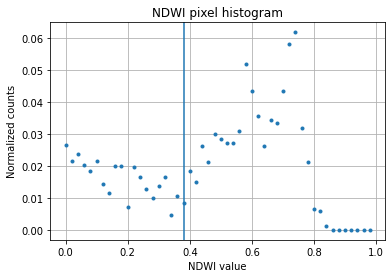

In [54]:
#retrieve the ndwi histogram from the image, calculate the Otsu threshold
hist = np.array(ndwi.select('B4_median').reduceRegion(ee.Reducer.fixedHistogram(0, 1, 50), roi, scale=3000).get('B4_median').getInfo())
thresh = hist2otsu(hist)

#plot the histogram and computed Otsu threshold
a = np.array(hist)
bins = a[:, 0]
normalized_counts = a[:, 1]/np.sum(a[:, 1])
plt.grid()
plt.plot(bins, normalized_counts, '.')
plt.title('NDWI pixel histogram')
plt.ylabel('Normalized counts')
plt.xlabel('NDWI value')
plt.axvline(thresh)
plt.show()

In [55]:
# Plot the thresholded image
url = binary.getThumbUrl({
    'min': 0, 'max': 1, 'dimensions': 512, 'region': roi,
    'palette': ['black', 'white']})
print('\nPlease wait while the thumbnail loads...')
Image(url=url)


Please wait while the thumbnail loads...
